In [1]:
import pandas as pd
import scanpy as sc
from anndata import AnnData
import numpy as np
from _utils import create_anndata
from pathlib import Path


In [2]:
# Day3_Markers_Dryad = pd.read_csv('Day3_Markers_Dryad.csv', delimiter=',', header=0,index_col=0)
if Path('protein_data.h5ad').exists():
    adata = sc.read_h5ad('protein_data.h5ad')
else:
    adata = create_anndata()
adata

/home/barroz/miniconda3/envs/scvi_cuda_2/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/barroz/miniconda3/envs/scvi_cuda_2/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/barroz/miniconda3/envs/scvi_cuda_2/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
/home/barroz/miniconda3/envs/scvi_cuda_2/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:406: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/barroz/miniconda3/envs/scvi_cuda_2/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:385: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(X, o

AnnData object with n_obs × n_vars = 5019159 × 57
    obs: 'cellid', 'donor', 'CCL5', 'Cell_Type_Common', 'Cell_Type_Sub', 'CD38', 'filename', 'region', 'x', 'y', 'Cell_Type', 'Overall_Cell_Type', 'Neighborhood', 'os_binary'
    uns: 'metadata'

In [3]:
print(adata.obs['donor'].value_counts())

donor
21_06_23_Melanoma    1529651
18_06_23_Melanoma     976931
14_06_23_Melanoma     593661
23_07_01_Melanoma     541059
05_06_23_Melanoma     472284
23_06_26_Melanoma     306068
23_07_03_Melanoma     219962
23_06_30_Melanoma     118650
23_07_06_Melanoma     102943
30_05_23_Melanoma      65639
23_06_23_Melanoma      63643
13_06_23_Melanoma      28668
Name: count, dtype: int64


In [4]:
adata_1 = adata[adata.obs['donor'] == '13_06_23_Melanoma']
adata_2 = adata[adata.obs['donor'] == '23_06_23_Melanoma']
# sc.pp.pca(adata_1)
# sc.pp.neighbors(adata_1)
# sc.pl.umap(adata_1, color='Cell_Type')
# sc.pl.pca(adata_1, color='Cell_Type')

/home/barroz/miniconda3/envs/scvi_cuda_2/lib/python3.10/site-packages/scanpy/plotting/_utils.py:487: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


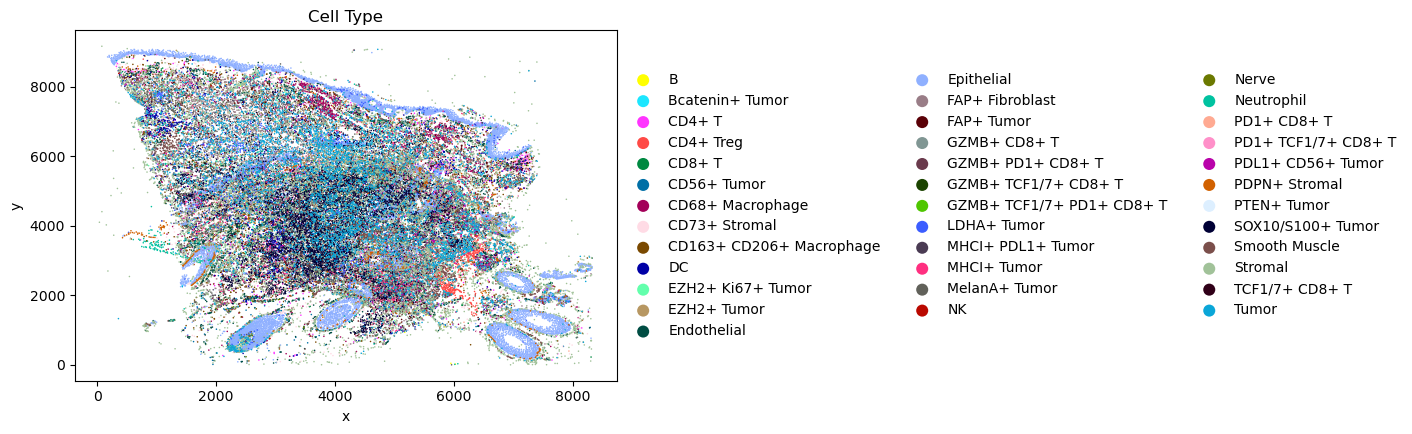

TypeError: unhashable type: 'list'

In [ ]:
sc.pl.scatter(adata_2, x='x', y='y', color='Overall_Cell_Type', size=5)
sc.pl.scatter(adata_2, x='x', y='y', color='Cell_Type', size=5)
sc.pl.scatter(adata_2, x='x', y='y', color='Neighborhood', size=5)
sc.pl.scatter(adata_2, x='x', y='y', color='Cell_Type_Sub', size=5)
sc.pl.scatter(adata_2, x='x', y='y', color='Cell_Type_Common', size=5)


In [ ]:
sc.pp.pca(adata_1)
sc.pp.neighbors(adata_1, n_neighbors=10,use_rep='X_pca')
sc.tl.umap(adata_1)
sc.pl.umap(adata_1, color='Cell_Type')

/home/barroz/miniconda3/envs/scvi_cuda_2/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


In [ ]:
# take the mean of the expression of each gene for each donor
for donor in adata.obs['donor'].unique():
    adata_donor = adata[adata.obs['donor'] == donor]
    adata_donor_mean = adata_donor.X.mean(axis=0)
    adata_donor_mean = adata_donor_mean.reshape(1, -1)
    adata_donor_mean = AnnData(X=adata_donor_mean, var=adata.var)
    adata_donor_mean.obs['donor'] = donor
    adata_donor_mean.obs['Cell_Type'] = 'mean'
    adata_ = adata.concatenate(adata_donor_mean, batch_key='donor')
    print(adata)

: 